In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

### VGG 16 선언 및 GAP 추가

In [143]:
class vgg_cam(nn.Module):
  def __init__(self, features, num_classes, init_weights=True):
    super(vgg_cam, self).__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.classfier = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.features(x)
    map = x
    x = self.avgpool(x)
    x = torch.squeeze(x)
    x = self.classfier(x)
    return x, map

In [144]:
vgg16 = models.vgg16(pretrained=True)
features = vgg16.features
model = vgg_cam(features=features,
                num_classes=10,
                init_weights=True)

model.features.load_state_dict(vgg16.features.state_dict())

<All keys matched successfully>

### preprocessing

In [120]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

### Dataset

In [145]:
train_dataset = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### GPU

In [146]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

vgg_cam(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

### hyperparams

In [123]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

### inference

In [ ]:
import random
i = random.randint(0, 64)
img = test_dataset[i][0]
label = test_dataset[i][1]
batch_img = img[None, :, :, :].to(device)
x, map = model(batch_img)

### CAM

In [159]:
class_weight = model.classfier.weight[label].unsqueeze(-1).unsqueeze(-1)
cam_ = torch.squeeze(map) * class_weight
cam = torch.sum(cam_, axis=0)
cam = cam.detach().cpu().numpy()

### Visualization

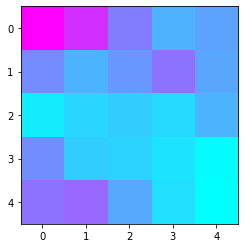

In [160]:
plt.imshow(cam, cmap='cool', interpolation='nearest')

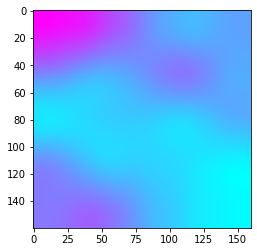

In [161]:
import cv2

final_cam = cv2.resize(cam, dsize=(160, 160), interpolation=cv2.INTER_CUBIC)
plt.imshow(final_cam, cmap='cool', interpolation='nearest')
plt.show()

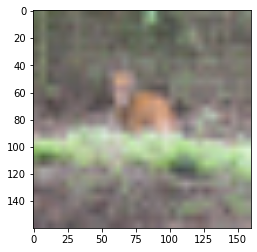

In [162]:
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
origin = inv_normalize(img[None, :, :, :])[0].detach().numpy()

plt.imshow(np.rollaxis(origin, 0, 3))

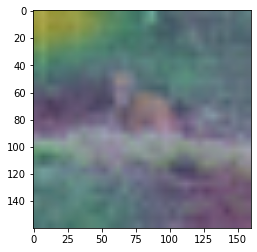

In [163]:
plt.imshow(np.rollaxis(origin, 0, 3))
plt.imshow(final_cam, alpha=0.4)
plt.show()